# Affine Matrix Function


### Objective

To compute $\mathrm{trace}(\mathbf{A} + t \mathbf{I})^{-1}$, where the parameter $t$ is varied.

This notebook will plot

* Accuracy of computing traceinv when compared with analytic solution for this matrix for each $t$.

### Matrix

Matrix $\mathbf{A} = \mathbf{C}^{\intercal} \mathbf{C}$ is a symmetric 3-band matrix and $\mathbf{C}$ is a 2-band matrix defined by

$$
    C_{ij} = 
    \begin{cases}
        \alpha, & i = j, \\
        \beta, & i+1 = j.
    \end{cases}
$$

The analytic value of $\mathrm{trace}(\mathbf{A}^{-1})$ is known by

$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - q^2 \frac{q^{2n} - 1}{q^2 - 1} \right),
$$
where $n$ is the size of the matrix and $q = \beta / \alpha \neq 1$. If $n \gg 1$
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - \frac{q^{2}}{1 - q^2} \right).
$$
If $q = 1$, then
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{n (n+1)}{2 \alpha^2}.
$$

### Consideratons

**parameters:**
* $\alpha = 2$, $\beta = 1$
* In SLQ method, `min_num_samples` and `max_num_samples` are fixed to 200.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used for all algorithms.
* Each result is repeated 10 times and the wall time is averaged between these 10 repeats. However, only the last repeat is used to store the value of traceinv. This is becase if we average traceinv between these repeats, the number of samples would be 10*200, not 200. But, we onlt want to show the error of traceinv for 200 samples.
* The results of all three methods are compared with the analytic value of traceinv given in the above.

**Notes:**

* Matrix is generated as sparse CSR.
* Only 64-bit data type is used.

### How to run the code

#### 1. Run locally

Run `/benchmark/scripts/affine_matrix_function.py` by

    cd /benchmark/scripts
    python ./affine_matrix_function.py
  

The outputs are stored in `/benchnmark/pickle_results/affine_matrix_function.pickle`.

#### 2. Run on cluster

To run on a cluster with TORQUE:

    cd jobfiles
    qsub jobfile_affine_matrix_function.pbs

In [1]:
import numpy
import numpy.polynomial.polynomial as poly
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
benchmark_dir = '..'
results_filename = join(benchmark_dir, 'pickle_results', 'affine_matrix_function.pickle')

with open(results_filename, 'rb') as file_:
    benchmark_result = pickle.load(file_)
    
print('Config:')
pp.pprint(benchmark_result['config'])
print('')
print('Matrix:')
pp.pprint(benchmark_result['matrix'])
print('')
print('Devices:')
pp.pprint(benchmark_result['devices'])

print('')
data_result = benchmark_result['data_result']
print('num data: %d' % len(data_result))

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'invert_cholesky': True,
    'lanczos_degree': 80,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': -1,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'symmetric': False,
    'verbose': False}

Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'dtype': 'float64',
    'format': 'csr',
    'size': 256,
    'symmetric': False,
    't': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.

In [3]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]


def line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    coefs = poly.polyfit(x, y, 1)
    yi = poly.polyval(xi, coefs)
    
    return yi


def log_line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_xi = numpy.log2(xi)
    log2_y = numpy.log2(y)
    
    coefs = poly.polyfit(log2_x, log2_y, 1)
    log2_yi = poly.polyval(log2_xi, coefs)
    
    return 2**log2_yi


def analytic_traceinv(matrix, t=0):
    """
    Analytic trace of inverse of banded matrix.
    """
    
    sizes = matrix['size']
    alpha = matrix['band_alpha']
    beta = matrix['band_beta']
    symmetric = matrix['symmetric']
    
    is_scalar = False
    if numpy.isscalar(sizes):
        sizes = numpy.array([sizes])
        is_scalar = True
        
    alpha = alpha + t
    
    if symmetric:
        
        if alpha == beta:
            M_traceinv = sizes * (sizes+1) / (2.0 * alpha**2)
        else:
            q = beta / alpha
            M_traceinv = numpy.zeros((sizes.size), dtype=float)
            
            for i in range(sizes.size):
                if sizes[i] < 200:
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * \
                        ( sizes - (q**2) *((q**(2.0*sizes) - 1.0) / (q**2 - 1.0)))
                else:
                    # Using assymptitic approximation of large sums
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * ( sizes - ((q**2) / (1.0 - q**2)))
            
    else:
        M_traceinv = sizes / alpha
        
    if is_scalar:
        return M_traceinv[0]
    else:
        return M_traceinv

Plot saved to "affine_matrix_function.svg".


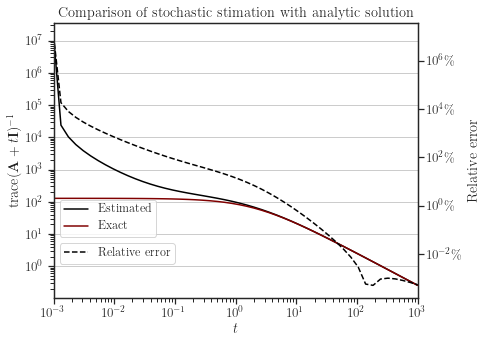

In [4]:
t = data_result['info']['matrix']['parameters']
absolute_error = data_result['info']['error']['absolute_error']
relative_error = data_result['info']['error']['relative_error']
trace = data_result['trace']
tau = trace / trace[0]

#trace_exact = numpy.empty_like(t)
#for i in range(t.size):
#    trace_exact[i] = analytic_traceinv(benchmark_result['matrix'], t[i])
trace_exact = benchmark_result['trace_exact']
tau_exact = trace_exact / trace_exact[0]

estimation_relative_error = numpy.abs((trace - trace_exact) / trace_exact)

## Plotting Elapsed time vs lanczos_degree
fig, ax = plt.subplots(figsize=(7, 5))
    
#ax.plot(t, tau, '-', color='black', label='Estimated')
#ax.plot(t, tau_exact, '-', color='maroon', label='Exact solution')
ax.plot(t, trace, '-', color='black', label='Estimated')
#ax.fill_between(t, trace-absolute_error, trace+absolute_error, color='gray', label='Error')
ax.plot(t, trace_exact, '-', color='maroon', label='Exact')

ax2 = ax.twinx()
ax2.plot(t, 100.0*estimation_relative_error, '--', color='black', label='Relative error')

# create blank rectangle
#extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
#handles = [extra, extra, extra, extra,
#           extra, handles[0], handles[2], handles[4], 
#           extra, handles[1], handles[3], extra]
#labels = ["", "32 bit", "64 bit", "128 bit",
#          "no BLAS", "", "", "",
#          "BLAS", "", "", ""]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2)
ax.legend(handles, labels, bbox_to_anchor=(0, 0.2), loc='lower left', ncol=1, fontsize='small')
ax2.legend(bbox_to_anchor=(0, 0.22),  loc='upper left', fontsize='small')
#ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)
    
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax2.set_yscale('log', base=10)
#ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(lanczos_degree)
ax.set_xlim([t[0], t[-1]])

#ax.set_ylabel('Elapsed time (relative to 32-bit no BLAS)')
#ax.set_ylabel('Process time (sec)')
#ax.set_ylabel(r'$\tau(t)$')
ax.set_ylabel(r'$\mathrm{trace}(\mathbf{A} + t \mathbf{I})^{-1}$')
ax2.set_ylabel(r'Relative error')
#ax.set_title('Elapsed Time v.s. Matrix Size')
ax.set_title('Comparison of stochastic stimation with analytic solution')
ax.set_xlabel(r'$t$')
ax.grid(axis='y')

plt.tight_layout()

# Save plot
save_dir = 'svg_plots'
filename_svg = 'affine_matrix_function.svg'
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=True, bbox_inches='tight')
print('Plot saved to "%s".' % (filename_svg))